In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('../data/train_5folds.csv')
df.head()

,Unnamed: 0,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,kfold
0,0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0
1,1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,2
2,2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,3
3,3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,3
4,4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,1


In [4]:
b = pd.cut(df.Pawpularity.values.tolist(), bins=10, retbins=True, labels=False)
b

(array([6, 4, 2, ..., 1, 1, 2]),
 array([  0.901,  10.9  ,  20.8  ,  30.7  ,  40.6  ,  50.5  ,  60.4  ,
         70.3  ,  80.2  ,  90.1  , 100.   ]))

In [5]:
type(b)

tuple

In [6]:
b[0]

array([6, 4, 2, ..., 1, 1, 2])

In [7]:
len(b[0])

9875

In [8]:
from ml.params import load_cfg

cfg = load_cfg(fpath="../params.yaml", cfg_name="train_two")
cfg.loss = 'crossentropy'
cfg.precision = 16
cfg.label_smoothing = 0.0
cfg.bs = 40
cfg.metric = 'accuracy'
cfg.metric_mode = 'max'
cfg

{'name': 'two', 'seed': 7591, 'n_folds': 5, 'fold': -1, 'metric': 'accuracy', 'metric_mode': 'max', 'train_data': 'data/train_224', 'arch': 'swin_large_patch4_window7_224', 'pretrained': True, 'epochs': 6, 'bs': 40, 'auto_batch_size': False, 'accumulate_grad_batches': 1, 'precision': 16, 'use_normalize': True, 'n_tfms': 1, 'magn': 5, 'sz': 224, 'use_mix': 0, 'mix_p': 0.0, 'resize': -1, 'dropout': 0.0, 'wd': 0.0, 'label_smoothing': 0.0, 'loss': 'crossentropy', 'opt': 'adamw', 'sched': 'cosine', 'warmup_epochs': 1, 'lr': 2.4e-05, 'auto_lr': False, 'mom': 0.9}

In [9]:
from pathlib import Path
from typing import List, Union

import pandas as pd
from omegaconf.omegaconf import OmegaConf


def get_image_paths_and_targets(
    df: pd.DataFrame,
    cfg: OmegaConf,
    include_extra: bool = False,
    target_format: str = "binary_classification",
) -> Union[List[Path], List[List[int]]]:

    # add image fpaths
    df["fpath"] = f"../data/train_{cfg.sz}/" + df.Id + ".jpg"

    image_paths = df.fpath.tolist()
    targets = df.Pawpularity.tolist()

    if include_extra:
        extra_df = pd.read_csv(constants.extra_labels_fpath)
        extra_df["fpath"] = f"../data/extra_{cfg.sz}/" + extra_df.Id + ".jpg"
        extra_image_paths = extra_df.fpath.tolist()
        image_paths += extra_image_paths

        extra_targets = extra_df[f"pseudo_label_fold{cfg.fold}"].tolist()
        targets += extra_targets

    if target_format == "binary_classification":
        targets = [t / 100.0 for t in targets]
    elif target_format == "multiclass_classification":
        targets = pd.cut(targets, bins=10, retbins=True, labels=False)[
            0
        ].tolist()
    elif target_format == "regression":
        pass
    else:
        raise ValueError(f"target_format {target_format} not supported yet.")

    return image_paths, targets


In [10]:
from pathlib import Path

path = Path("../data/train_224")

train_image_paths, train_targets = get_image_paths_and_targets(df=df, cfg=cfg, target_format='multiclass_classification')
train_image_paths, train_targets = train_image_paths[:100], train_targets[:100]
val_image_paths, val_targets = train_image_paths, train_targets

In [11]:
len(train_image_paths), len(train_targets)

(100, 100)

In [12]:
from timm.data import transforms_factory

train_aug = transforms_factory.create_transform(
    input_size=224,
    is_training=True,
    auto_augment=f"rand-n2-m3",
)
val_aug = transforms_factory.create_transform(
    input_size=224,
    is_training=False,
)

In [13]:
from ml.vision.data import ImageDataModule

dm = ImageDataModule(
    task="classification",
    batch_size=cfg.bs,
    # train
    train_image_paths=train_image_paths,
    train_targets=train_targets,
    train_augmentations=train_aug,
    # valid
    val_image_paths=val_image_paths,
    val_targets=val_targets,
    val_augmentations=val_aug,
)
dm.setup()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


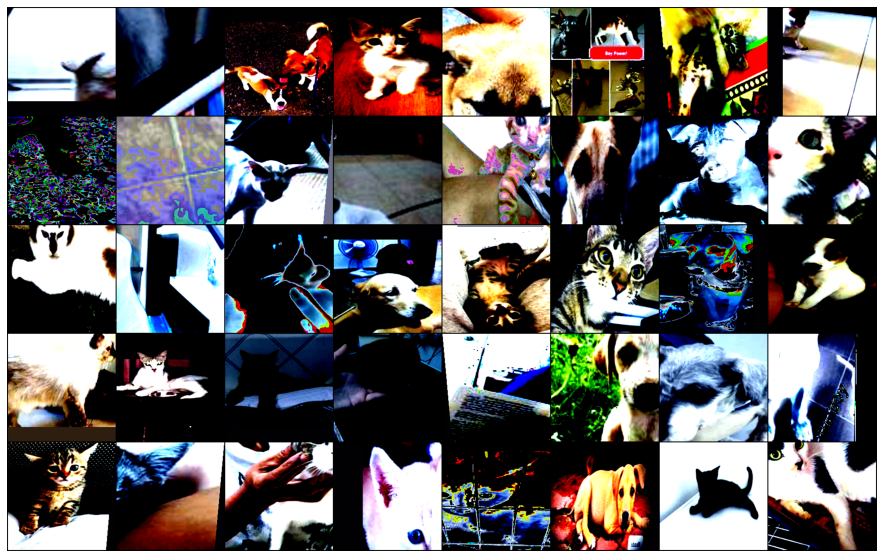

In [14]:
from ml.vision.utils import plot_batches
import matplotlib.pyplot as plt

plot_batches(dm.train_dataloader())

In [15]:
for batch in dm.train_dataloader():
    x, y = batch
    print(y)
    break

tensor([3, 1, 6, 4, 3, 2, 3, 5, 1, 5, 1, 2, 4, 0, 4, 1, 3, 5, 2, 3, 2, 3, 3, 1,
        3, 2, 4, 5, 3, 8, 5, 1, 6, 4, 4, 7, 1, 2, 2, 7])


In [16]:
from typing import Any, List, Optional

import pytorch_lightning as pl
from omegaconf import OmegaConf
from timm.models import create_model
from torch import nn

from ml.loss import loss_factory
from ml.metrics import metric_factory
from ml.optim import lr_scheduler_factory, optimizer_factory
from ml.vision.augmentations import BatchRandAugment


class ImageMulticlassClassifier(pl.LightningModule):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        cfg: OmegaConf,
        pretrained: bool = False,
    ) -> None:
        super().__init__()
        self.save_hyperparameters(cfg)

        self.backbone = create_model(
            model_name=self.hparams.arch,
            pretrained=pretrained,
            num_classes=0,
            in_chans=in_channels,
            drop_rate=self.hparams.dropout,
        )
        self.head = nn.Sequential(
            nn.LazyLinear(128),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.Linear(64, num_classes),
        )

        self.train_metric = metric_factory(name=cfg.metric)
        self.val_metric = metric_factory(name=cfg.metric)
        self.best_train_metric = None
        self.best_val_metric = None

    def forward(self, x):
        """Contain only tensor operations with your model."""
        x = self.backbone(x)
        x = self.head(x)
        return x

    def training_step(self, batch, batch_idx):
        """Encapsulate forward() logic with logging, metrics, and loss
        computation.
        """
        x, target = batch

        loss, target, preds = self._step(x, target)

        if len(target.shape) == 1:
            pass
        elif target.shape[1] == 3:  # if using MixUp, compute target
            lam = target[:, 2]
            target = (1 - lam) * target[:, 0] + lam * target[:, 1]
            target = target.reshape(-1, 1)

        self.log("train_loss", loss, on_step=True, on_epoch=False)
        self.train_metric.update(preds=preds, target=target)
        return loss

    def training_epoch_end(self, outputs) -> None:
        self.log("train_metric", self.train_metric.compute())

    def validation_step(self, batch, batch_idx):
        x, target = batch

        loss, target, preds = self._step(x, target)
        self.log("val_loss", loss, on_step=True, on_epoch=False)
        self.val_metric.update(preds=preds, target=target)
        return loss

    def validation_epoch_end(self, outputs: List):
        self.log("val_metric", self.val_metric.compute())
        self._register_best_train_and_val_metrics()
        # BUG: the metrics for the very last epoch are not printed
        # but are nonetheless logged in neptune
        self._print_metrics_to_console()

    def predict_step(
        self, batch: Any, batch_idx: int, dataloader_idx: Optional[int] = None
    ) -> Any:
        """Encapsulate forward() with any necessary preprocess or postprocess
        functions.
        """
        x = batch

        preds = self.forward(x)
        # TODO: we don't always need a sigmoid. Handle that case.
        outs = preds
        outs = preds.argmax(dim=1)
        return outs.detach().cpu().float().numpy()

    def _step(self, x, target):
        preds = self.forward(x)
        # TODO: handle logit vs. no logit case for both loss and preds
        loss = self._compute_loss(preds=preds, target=target)
        preds = preds.argmax(dim=1)
        return loss, target, preds

    def configure_optimizers(self):
        optimizer = optimizer_factory(
            params=self.parameters(), hparams=self.hparams
        )

        scheduler = lr_scheduler_factory(
            optimizer=optimizer,
            hparams=self.hparams,
            data_loader=self.trainer.datamodule.train_dataloader(),
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
                "monitor": "val_metric",
                "strict": True,
                "name": "lr",
            },
        }

    def _compute_loss(self, preds, target):
        if self.hparams.label_smoothing > 0.0:
            target = (
                target * (1 - self.hparams.label_smoothing)
                + 0.5 * self.hparams.label_smoothing
            )

        loss_fn = loss_factory(name=self.hparams.loss)
        loss = loss_fn(preds, target)
        return loss

    def _register_best_train_and_val_metrics(self):
        try:
            train_metric = self.trainer.callback_metrics["train_metric"]
            val_metric = self.trainer.callback_metrics["val_metric"]
            if self.best_val_metric is None or self._is_metric_better(
                val_metric
            ):
                self.best_val_metric = val_metric
                self.best_train_metric = train_metric
        except (KeyError, AttributeError):
            # these errors occurs when in "tuning" mode (find optimal lr)
            pass

    def _is_metric_better(self, new_metric):
        if self.hparams.metric_mode == "max":
            return new_metric > self.best_val_metric
        elif self.hparams.metric_mode == "min":
            return new_metric < self.best_val_metric
        else:
            raise ValueError("metric_mode can only be min or max")

    def _print_metrics_to_console(self):
        try:
            train_metric = self.trainer.callback_metrics["train_metric"]
            val_metric = self.trainer.callback_metrics["val_metric"]
            self.trainer.progress_bar_callback.main_progress_bar.write(
                f"Epoch {self.current_epoch} // "
                f"train metric: {train_metric:.4f}, valid metric: {val_metric:.4f}"
            )
        except (KeyError, AttributeError):
            # these errors occurs when in "tuning" mode (find optimal lr)
            pass

In [17]:
model = ImageMulticlassClassifier(in_channels=3, num_classes=10, cfg=cfg)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2156.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [18]:
trainer = pl.Trainer(gpus=1, max_epochs=cfg.epochs)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/model_summary.py:431: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name         | Type            | Params
-------------------------------------------------
0 | backbone     | SwinTransformer | 194 M 
1 | head         | Sequential      | 8.9 K 
2 | train_metric | Accuracy        | 0     
3 | val_metric   | Accuracy        | 0     
-------------------------------------------------
195 M     Trai

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 1 // train metric: 0.0500, valid metric: 0.2179


Validating: 0it [00:00, ?it/s]

Epoch 2 // train metric: 0.1187, valid metric: 0.2447


Validating: 0it [00:00, ?it/s]

Epoch 3 // train metric: 0.1875, valid metric: 0.2562


Validating: 0it [00:00, ?it/s]

Epoch 4 // train metric: 0.2250, valid metric: 0.2655


Validating: 0it [00:00, ?it/s]

Epoch 5 // train metric: 0.2250, valid metric: 0.2706


In [19]:
preds = []
for batch in dm.val_dataloader():
    x, y = batch
    preds = model(x)


In [20]:
preds

tensor([[-1.5190, -0.0186,  1.7025,  0.6931,  0.5339,  0.2794, -0.3189, -1.3205,
         -2.0527, -0.4506],
        [-1.4023,  0.5610,  0.6839,  1.2758,  1.0493,  0.4801, -0.4471, -1.2782,
         -1.3607, -0.4106],
        [-1.4731,  0.1426,  1.1180,  0.8757,  0.8380,  0.4363, -0.1645, -1.5640,
         -1.7839, -0.3592],
        [-1.1332,  0.7468,  0.3997,  1.2830,  0.8744,  0.0806, -0.3512, -1.0777,
         -0.9190, -0.5468],
        [-1.1844,  0.6197,  0.8926,  1.2488,  0.8381, -0.0585, -0.4463, -1.2667,
         -1.2357, -0.4401],
        [-1.3018,  1.0547,  0.2981,  1.5537,  0.9824,  0.0232, -0.1078, -1.1360,
         -1.2638, -0.5122],
        [-1.5739,  0.6147,  0.5147,  1.2491,  0.7489,  0.3954, -0.3611, -1.6794,
         -1.4818, -0.4839],
        [-1.5901,  0.5214,  1.1818,  1.1880,  0.8443,  0.5802, -0.1718, -1.5794,
         -1.7741, -0.4167],
        [-1.2221,  0.6481,  0.5920,  1.1351,  0.6707,  0.2676, -0.0576, -1.0075,
         -1.3695, -0.6574],
        [-1.4160,  

In [29]:
print(preds.argmax(dim=1))
print(y)

tensor([2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3])
tensor([2, 2, 3, 4, 5, 4, 9, 3, 3, 5, 1, 3, 3, 4, 5, 4, 4, 4, 1, 1])


In [34]:
from torchmetrics import Accuracy

acc = Accuracy()
acc(preds.argmax(dim=1), y)

tensor(0.2000)

In [21]:
import torch 
upreds = torch.randn(10, 5).softmax(dim=-1)
utarget = torch.randint(5, (10,))

In [22]:
upreds

tensor([[0.0322, 0.1279, 0.3727, 0.3772, 0.0900],
        [0.1006, 0.4242, 0.1412, 0.2180, 0.1160],
        [0.2151, 0.0253, 0.3225, 0.0873, 0.3498],
        [0.1033, 0.5986, 0.1016, 0.1455, 0.0510],
        [0.0210, 0.1623, 0.1862, 0.1147, 0.5158],
        [0.2299, 0.1926, 0.0620, 0.4398, 0.0757],
        [0.2682, 0.6210, 0.0182, 0.0514, 0.0412],
        [0.0888, 0.3595, 0.3305, 0.0693, 0.1520],
        [0.0929, 0.1549, 0.2360, 0.3029, 0.2133],
        [0.2918, 0.0612, 0.1278, 0.0214, 0.4977]])

In [23]:
utarget

tensor([2, 0, 0, 2, 2, 2, 4, 1, 0, 0])

In [25]:
upreds = torch.randn(10, 5).softmax(dim=-1)
utarget = torch.randint(5, (10,))